In [1]:
import psutil
from subprocess import PIPE
import shlex
from time import sleep
import regex
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def run_km_constrained(n, d, k, min_clusters=None, max_clusters=None):
    cmd = f'./benchmark_k_means_constrained.py -n {n} -d {d} -K {k}'
    if min_clusters:
        cmd += f' -ge {min_clusters}'
    if max_clusters:
        cmd += f' -le {max_clusters}'
    p = psutil.Popen(shlex.split(cmd), stdout=PIPE)
    peak_mem = 0
    output = ""
    while p.is_running():
        sleep(0.1) # Sample frequency
        # "Resident Set Size"/physical memory used in bytes
        peak_mem = max(p.memory_info().rss, peak_mem)
        output += str(p.communicate()[0])

    # Time
    time = regex.search(r'Total time: (\d*\.\d*) seconds', output)
    try:
        time = float(time.groups()[0])
    except AttributeError:
        print('k-means-constrained failed:', cmd)
        return None, float(peak_mem)
    return time, float(peak_mem)

def run_km(n, d, k):
    cmd = f'./benchmark_k_means.py -n {n} -d {d} -K {k}'
    p = psutil.Popen(shlex.split(cmd), stdout=PIPE)
    peak_mem = 0
    output = ""
    while p.is_running():
        sleep(0.1) # Sample frequency
        # "Resident Set Size"/physical memory used in bytes
        peak_mem = max(p.memory_info().rss, peak_mem)
        output += str(p.communicate()[0])

    # Time
  
    time = regex.search(r'Total time: (\d*\.\d*) seconds', output)
    try:
        time = float(time.groups()[0])
    except AttributeError:
        print('k-means failed:', cmd)
        return None, float(peak_mem)
    return time, float(peak_mem)

In [3]:
run_km_constrained(10, 2, 4, min_clusters=1, max_clusters=8)

(0.34, 21581824.0)

In [4]:
run_km(10, 2, 4)

(0.03, 21663744.0)

In [5]:
# Fixed x and d. Increase cluster size (no min or max)
k = [1, 10, 25, 50, 75, 100, 250, 500, 750, 1000]
x = [10*ki for ki in k]
d = 10
min_clusters = None
max_clusters = None
km_time, km_mem = list(zip(*[run_km(xi, d, ki) for ki, xi in tqdm(zip(k, x), desc='k-means')]))
con_time, con_mem = list(zip(*[run_km_constrained(xi, d, ki) for ki, xi in tqdm(zip(k, x), desc='k-means-constrained')]))

k-means: 10it [00:27,  2.73s/it]
k-means-constrained: 10it [04:26, 26.64s/it]


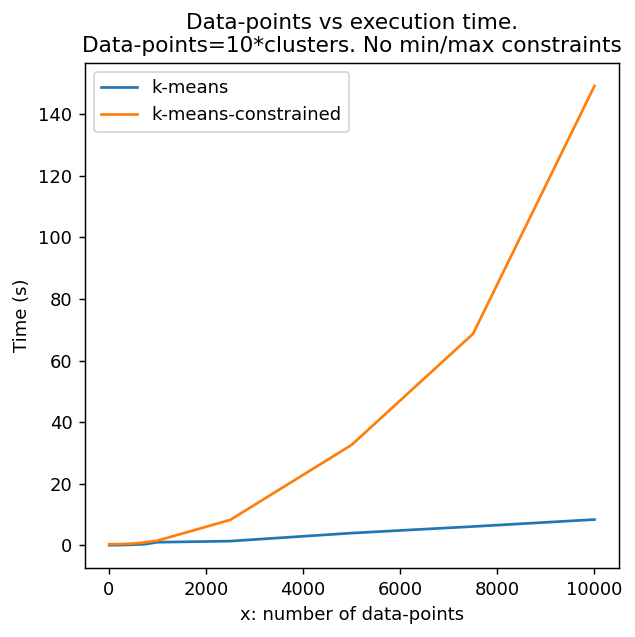

In [19]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5), dpi=130)

ax1.plot(x, km_time, label='k-means')
ax1.plot(x, con_time, label='k-means-constrained')

ax1.set_xlabel('x: number of data-points')
ax1.set_ylabel('Time (s)')
ax1.set_title('Data-points vs execution time.\nData-points=10*clusters. No min/max constraints')
ax1.legend()

plt.tight_layout()

plt.show()

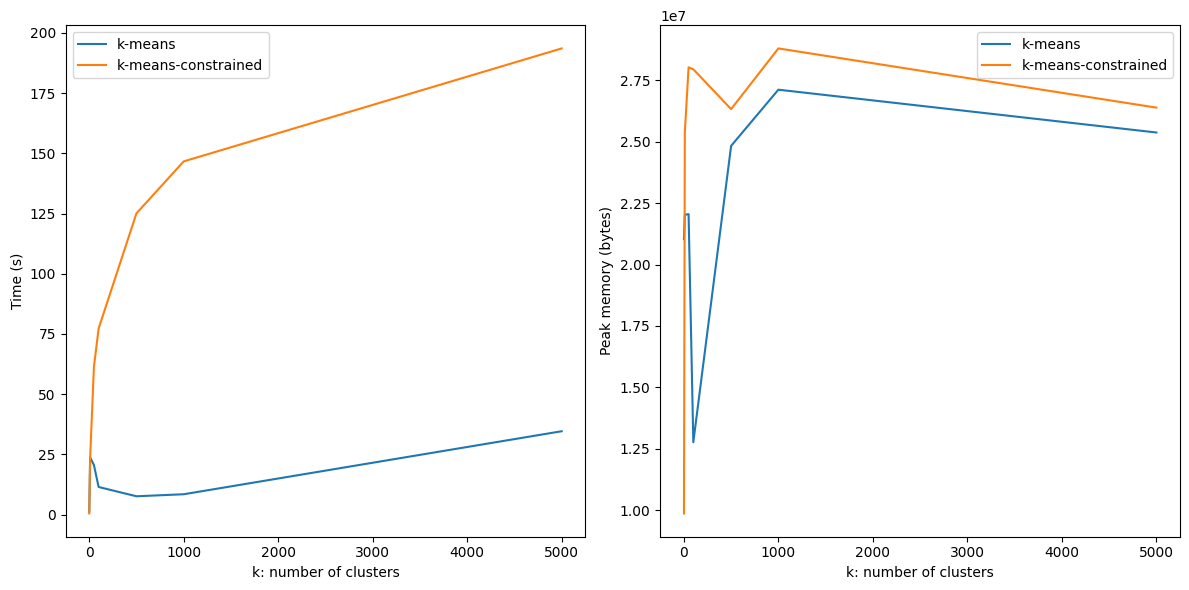

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(x, km_time, label='k-means')
ax1.plot(x, con_time, label='k-means-constrained')

ax1.set_xlabel('x: number of data-points')
ax1.set_ylabel('Time (s)')
#ax1.set_title('First Plot')
ax1.legend()

ax2.plot(x, km_mem, label='k-means')
ax2.plot(x, con_mem, label='k-means-constrained')

ax2.set_xlabel('x: number of data-points')
ax2.set_ylabel('Peak memory (bytes)')
#ax2.set_title('Second Plot')
ax2.legend()

plt.tight_layout()

plt.show()

In [57]:
# Fixed x, d, k. Increase min_cluster
x = 10000
d = 10
k = 10 #list(range(1, x//2, 10))
min_clusters = [1, 10, 50, 100, 250, 500, 750, 1000]
max_clusters = None
#km_time, km_mem = list(zip(*[run_km(x, d, k)]))
con_time, con_mem = list(zip(*[run_km_constrained(x, d, k, min_clusters=mc) for mc in tqdm(min_clusters, desc='k-means-constrained')]))

k-means-constrained: 100%|██████████| 8/8 [03:26<00:00, 25.77s/it]


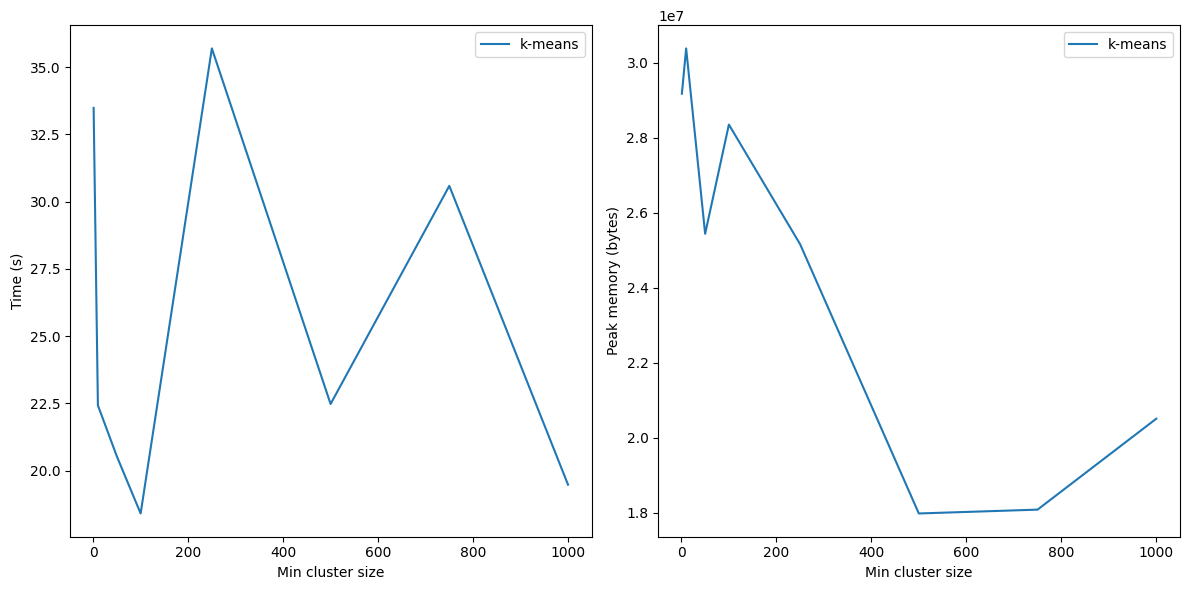

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(min_clusters, con_time, label='k-means-constrained')

ax1.set_xlabel('Min cluster size')
ax1.set_ylabel('Time (s)')
#ax1.set_title('First Plot')
ax1.legend()

ax2.plot(min_clusters, con_mem, label='k-means-constrained')

ax2.set_xlabel('Min cluster size')
ax2.set_ylabel('Peak memory (bytes)')
#ax2.set_title('Second Plot')
ax2.legend()

plt.tight_layout()

plt.show()

In [62]:
# Fixed x, d, k. Increase max_cluster
x = 10000
d = 10
k = 100 #list(range(1, x//2, 10))
min_clusters = None
max_clusters = [100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000]
#km_time, km_mem = list(zip(*[run_km(x, d, k)]))
con_time, con_mem = list(zip(*[run_km_constrained(x, d, k, max_clusters=mc) for mc in tqdm(max_clusters, desc='k-means-constrained')]))

k-means-constrained: 100%|██████████| 9/9 [13:45<00:00, 91.77s/it] 


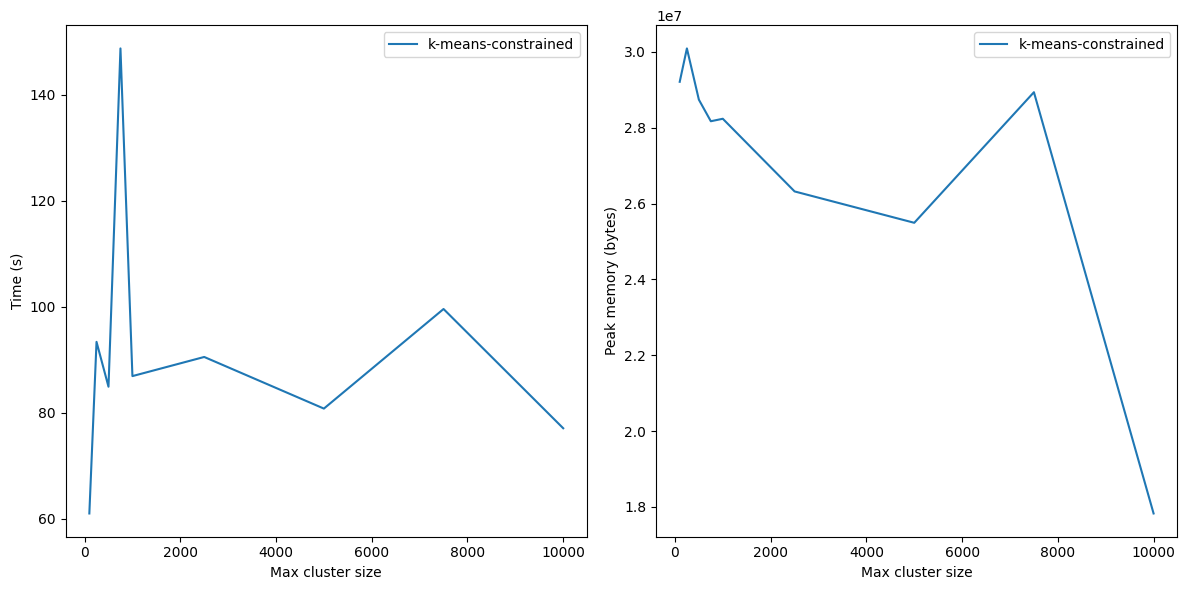

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(max_clusters, con_time, label='k-means-constrained')

ax1.set_xlabel('Max cluster size')
ax1.set_ylabel('Time (s)')
#ax1.set_title('First Plot')
ax1.legend()

ax2.plot(max_clusters, con_mem, label='k-means-constrained')

ax2.set_xlabel('Max cluster size')
ax2.set_ylabel('Peak memory (bytes)')
#ax2.set_title('Second Plot')
ax2.legend()

plt.tight_layout()

plt.show()